# Number Density as a Function of Redshift

## Learning Goals
- learn how to use the mock simulations for Roman Space Telescope [Zhai et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.501.3490Z/abstract ) 
- modify code to reduce memory usage when using large catalogs
- make a plot of number density of galaxies as a function of redshift (recreate figure 3 from [Wang et al., 2021](https://arxiv.org/pdf/2110.01829)).

## Introduction
The Nancy Grace Roman Space Telescope will be a transformative tool for cosmology due to its unprecedented combination of wide field-of-view and high-resolution imaging. We choose to demonstrate the usefulness of the mock Roman suimulations in generating number density plots because they provide crucial insights into the large-scale structure of the universe and the distribution of matter over cosmic time. These plots illustrate how the number density of galaxies, quasars, or dark matter halos changes with redshift, revealing information about the processes of galaxy formation, evolution, and clustering. By analyzing number density plots, cosmologists can test theoretical models of structure formation, constrain cosmological parameters, and understand the influence of dark matter and dark energy on the evolution of the universe.

### Instructions
Most of the notebook can be run with a single mock galaxy catalog file which easily fits in memory (3G). The final section uses all the data to make a final number density plot.  The dataset in its entirety does not fit into memory all at once(out of memory) so we have carefully designed this function to use the least possible amount of memory.  The dataset in its entirety also takes ~30 minutes to download and requires ~30G of space to store.  We suggest only running download_simulations with download_all= True if you are ready to wait for the download and have enough storage space.  Default is to work with only one catalog which is 10% of the dataset.

Techniques employed for working with out of memory datasets:

    - read in only some columns from the original dataset
    - convert data from float64 to float32 where high precision is not necessary
    - careful management of the code structure to not need to read in all datasets to one dataframe

### Input
- None, the location of the simulated dataset is hardcoded for convenience
  
### Output
- plots of number of galaxies per square degree as a function of redshift
- optional numpy file with the counts saved for ease of working with the information later

## Imports

In [1]:
# Uncomment the next line to install dependencies if needed.
# !pip install h5py pandas matplotlib numpy requests

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import concurrent.futures
import re
import h5py
import requests

%matplotlib inline

## 1. Read in the mock catalogs from IRSA 
- figure out how to get the files from IRSA
- pull down one of them for testing
- convert to a pandas df for ease of use
- do some data exploration

### 1.1 Download the files from IRSA
- This is about 30G of data in total

In [3]:
def download_file(file_url, save_path):
    """
    Downloads a file from a given URL and saves it to a specified local path.
    The file is downloaded in chunks to reduce memory usage.

    Parameters:
    - file_url (str): The URL of the file to download.
    - save_path (str): The local path where the file will be saved.

    Returns:
    - str: The save_path if the download succeeds.

    Raises:
    - requests.HTTPError: If the HTTP request returned an unsuccessful status code.
    - OSError: If there is an issue creating directories or writing the file.
    """
    response = requests.get(file_url, stream=True)
    response.raise_for_status()  # Raise an HTTPError for bad responses (4xx, 5xx)

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):  # 8KB chunks
            if chunk:  # Filter out keep-alive chunks
                f.write(chunk)

    print(f"Downloaded: {save_path}")
    return save_path


def download_files_in_parallel(file_url_list, save_dir):
    """
    Downloads multiple files in parallel using a ThreadPoolExecutor.

    Parameters:
    - file_url_list (list of str): List of file URLs to download.
    - save_dir (str): Directory where files will be saved.

    Returns:
    - list of str: List of paths where the files were successfully downloaded.
    """
    downloaded_files = []
    #set to a reasonable number for efficiency and scalability
    max_workers = min(len(file_url_list), os.cpu_count() * 5, 32)  
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_url = {
            executor.submit(download_file, url, os.path.join(save_dir, os.path.basename(url))): url 
            for url in file_url_list
        }
        
        for future in concurrent.futures.as_completed(future_to_url):
            file_path = future.result()
            if file_path:
                downloaded_files.append(file_path)

    return downloaded_files

def download_simulations(download_dir, download_all=True):
    """
    Download .hdf5 simulation files from the Roman Zhai2021 URL using the provided checksums.md5 file.

    This function reads the list of available .hdf5 files from the checksums.md5 file, filters them,
    and downloads the requested files to a specified directory. If a file already exists locally,
    it will be skipped.

    Parameters
    ----------
    download_dir : str
        Directory where the downloaded .hdf5 files will be stored. 
        The directory will be created if it does not already exist.

    download_all : bool, optional
        If True, download all .hdf5 files listed in the checksum file.
        If False, download only the first file. Default is True.

    Returns
    -------
    None
        This function does not return any value but prints the download status.

    Notes
    -----
    - Downloads are performed in parallel using a maximum of 4 workers.
    - Files that already exist locally are skipped.
    """
    base_url = 'https://irsa.ipac.caltech.edu/data/theory/Roman/Zhai2021'
    checksum_url = f'{base_url}/checksums.md5'

    # Read the checksums file to get the filenames
    df = pd.read_csv(checksum_url, sep=r"\s+", names=["checksum", "filename"])
    hdf5_files = df[df["filename"].str.endswith(".hdf5")]["filename"].tolist()

    if not download_all:
        hdf5_files = hdf5_files[:1]

    file_urls = [f"{base_url}/{fname}" for fname in hdf5_files]

    os.makedirs(download_dir, exist_ok=True)

    # Filter out files that already exist
    files_to_download = []
    for file_url in file_urls:
        filename = os.path.basename(file_url)
        file_path = os.path.join(download_dir, filename)
        if os.path.exists(file_path):
            print(f"The file {filename} already exists. Skipping download.")
        else:
            files_to_download.append(file_url)

    if files_to_download:
        print(f"Starting parallel download of {len(files_to_download)} files.")
        downloaded_files = download_files_in_parallel(files_to_download, download_dir)
        print(f"Successfully downloaded {len(downloaded_files)} files.")
    else:
        print("All requested files are already downloaded.")

In [4]:
# Set download_all to True to download all files, or False to download only the first file
# only a single downloaded file is required to run the notebook in its entirety, 
# however section 4 will be more accuate with all 10 files

# Downloading 10 files, each 3GB in size, may take between 1 and 30 minutes,
# or even longer, depending on your proximity to the data.

download_dir = 'downloaded_hdf5_files'
download_simulations(download_dir, download_all=False)

Starting parallel download of 1 files.
Downloaded: downloaded_hdf5_files/Roman_small_V2_0.hdf5
Successfully downloaded 1 files.


Downloaded: downloaded_hdf5_files/Roman_small_V2_0.hdf5
Successfully downloaded 1 files.


### 1.2 read files into a pandas dataframe so we can work with them

In [5]:
def fetch_column_names():
    """
    Fetches column names from the Readme_small.txt file at the specified URL.

    Returns:
    - List of column names (str): A list of extracted column names, or an empty list if no column names are found.

    Raises:
    - HTTPError: If the HTTP request returns an unsuccessful status code.
    """
    import requests
    import re

    url = 'https://irsa.ipac.caltech.edu/data/theory/Roman/Zhai2021/Readme_small.txt'
    response = requests.get(url)
    response.raise_for_status()  # Raise an HTTPError for bad responses

    lines = response.text.splitlines()
    column_names = []

    for line in lines:
        if line.strip().lower().startswith('column'):
            match = re.search(r':\s*([^\s]+)', line)
            if match:
                column_names.append(match.group(1))

    if column_names:
        return column_names
    else:
        print("No column names found in Readme_small.txt.")
        return []



def read_hdf5_to_pandas(file_path, columns_to_keep, columns_to_convert):
    """
    Read selected columns from an HDF5 file into a pandas DataFrame.

    Parameters
    ----------
    file_path : str
        Path to the HDF5 file.
    columns_to_keep : list of str
        List of column names to extract from the dataset.
    columns_to_convert : list of str
        List of column names to convert to float32 for memory efficiency.

    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the selected columns from the HDF5 file, 
        with specified columns cast to float32.
    """
    # Map of column names to their corresponding index in the HDF5 dataset
    col_map = {
        "RA": 0,
        "DEC": 1,
        "redshift_cosmological": 2,
        "redshift_observed": 3,
        "velocity": 4,
        "stellar": 5,
        "SFR": 6,
        "halo": 7,
        "flux_Halpha6563": 8,
        "flux_OIII5007": 9,
        "M_F158_Av1.6523": 10,
        "nodeIsIsolated": 11
    }

    # Open the HDF5 file and extract only the requested columns
    with h5py.File(file_path, "r") as file:
        dataset = file["data"]
        data = {}
        for col in columns_to_keep:
            idx = col_map[col]
            data[col] = dataset[:, idx]

    # Create a DataFrame from the selected columns
    df = pd.DataFrame(data)

    # Convert specified columns to float32 to reduce memory usage
    conversion_map = {col: "float32" for col in columns_to_convert}
    df = df.astype(conversion_map)

    return df

def assign_redshift_bins(df, z_min, z_max, dz=0.1):
    """
    Assign redshift bins to a DataFrame based on 'redshift_observed'.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame containing a 'redshift_observed' column.
    z_min : float
        The minimum redshift for binning.
    z_max : float
        The maximum redshift for binning.
    dz : float, optional
        The redshift bin width (default is 0.1).

    Returns
    -------
    df : pandas.DataFrame
        The input DataFrame with a new 'z_bin' categorical column.
    z_bins : numpy.ndarray
        The redshift bin edges used to define bins.
    z_bin_centers : list of float
        The central redshift value for each bin.
    """
    z_bins = np.arange(z_min, z_max + dz, dz)
    df["z_bin"] = pd.cut(df["redshift_observed"], bins=z_bins, include_lowest=True, right=False)
    z_bin_centers = [np.mean([b.left, b.right]) for b in df["z_bin"].cat.categories]
    z_bin_centers = sorted(z_bin_centers)
    return df, z_bins, z_bin_centers

In [6]:
#don't change this, the above code downloads the files to this directory
file_path = 'downloaded_hdf5_files/Roman_small_V2_0.hdf5'

#out of consideration for the size of these files and the amount of memory required to work with them
# we only keep the columns that we are going to use and convert some to 32bit instead of 64 where 
# the higher precision is not necessary to the science
columns_to_keep = ['RA', 'DEC', 'redshift_observed', 'flux_Halpha6563']
columns_to_convert = ['redshift_observed', 'flux_Halpha6563']

df = read_hdf5_to_pandas(file_path, columns_to_keep, columns_to_convert)

### 1.3 Pre-process dataset
Add some value-added columns to the dataframe, and calculate some variables which are used by mulitple functions

In [7]:
#add a binned redshift column and calculate the edges of the bins
z_min = 1.0
z_max = 3.0
dz = 0.1
df, z_bins, z_bin_centers = assign_redshift_bins(df, z_min=z_min, z_max=z_max, dz=dz)

#Shift RA values to continuous range for the entire DataFrame 
#This is necessary because the current range goes over 360 which appears to the code 
#as a non-contiguous section of the sky.  By shifting the RA values, we don't have the 
#jump from RA = 360 to RA = 0.  
    
ra_min1=330
df['RA_shifted'] = (df['RA'] - ra_min1) % 360  # Shift RA to continuous range

In [8]:
#quick check to see what we've got:
df

,RA,DEC,redshift_observed,flux_Halpha6563,z_bin,RA_shifted
0,341.509710,7.693022,4.090425,2.438628e-16,NaN,11.509710
1,357.329659,-4.205828,4.200562,2.290115e-16,NaN,27.329659
2,348.470261,19.136800,3.704146,3.427580e-16,NaN,18.470261
3,5.120387,6.377602,3.750228,3.328315e-16,NaN,35.120387
4,21.632080,2.866344,3.677756,3.486357e-16,NaN,51.632080
...,...,...,...,...,...,...
29382938,338.240811,16.178767,0.067884,1.876826e-15,NaN,8.240811
29382939,346.041731,4.151812,0.059724,2.956311e-15,NaN,16.041731
29382940,13.633021,-18.561325,0.080929,4.737627e-14,NaN,43.633021
29382941,4.662985,4.162972,0.050005,4.001319e-15,NaN,34.662985


### 1.3 Data Exploration
Let's explore the dataset a bit to see what we are working with.

This function prints the following information:
- First 5 rows of the DataFrame.
- DataFrame info (data types, non-null counts).
- Summary statistics for numeric columns.
- Memory usage of the DataFrame and each column.
- Column names.
- Check for missing (NaN) values, including columns with NaNs and their counts.

Note that quite a few of the z_bin values are NaN because they are outside the redshift range of interest for this plot (1 < z < 3)

In [9]:
# Display the first 5 rows of the dataframe
df.head()

,RA,DEC,redshift_observed,flux_Halpha6563,z_bin,RA_shifted
0,341.509710,7.693022,4.090425,2.438628e-16,NaN,11.509710
1,357.329659,-4.205828,4.200562,2.290115e-16,NaN,27.329659
2,348.470261,19.136800,3.704146,3.427580e-16,NaN,18.470261
3,5.120387,6.377602,3.750228,3.328315e-16,NaN,35.120387
4,21.632080,2.866344,3.677756,3.486357e-16,NaN,51.632080


In [10]:
# Get general information about the dataframe (e.g., data types, non-null counts)
print("\nDataFrame info (Data Types, Non-null counts):")
df.info()


DataFrame info (Data Types, Non-null counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29382943 entries, 0 to 29382942
Data columns (total 6 columns):
 #   Column             Dtype   
---  ------             -----   
 0   RA                 float64 
 1   DEC                float64 
 2   redshift_observed  float32 
 3   flux_Halpha6563    float32 
 4   z_bin              category
 5   RA_shifted         float64 
dtypes: category(1), float32(2), float64(3)
memory usage: 924.7 MB


In [11]:
# Display summary statistics for numeric columns
print("\nSummary statistics for numeric columns:")
df.describe()


Summary statistics for numeric columns:


,RA,DEC,redshift_observed,flux_Halpha6563,RA_shifted
count,2.938294e+07,2.938294e+07,2.938294e+07,2.938294e+07,2.938294e+07
mean,1.802166e+02,-2.749608e-03,1.096546e+00,2.976948e-16,2.996636e+01
std,1.689970e+02,1.257703e+01,5.805780e-01,4.253355e-15,1.287226e+01
min,1.164220e-06,-2.249985e+01,3.921282e-03,1.660502e-18,7.500002e+00
25%,1.105467e+01,-1.078845e+01,6.446358e-01,5.264885e-17,1.889303e+01
50%,3.375331e+02,2.420867e-02,9.980963e-01,1.034983e-16,2.997017e+01
75%,3.489236e+02,1.077922e+01,1.473502e+00,2.202762e-16,4.102419e+01
max,3.600000e+02,2.249999e+01,5.055577e+00,8.686074e-12,5.250000e+01


In [12]:
# Print memory usage of the DataFrame
print("\nMemory usage of the DataFrame:")
print(df.memory_usage(deep=True))  # Shows memory usage of each column
print(f"Total memory usage: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")  # Total memory usage in MB


Memory usage of the DataFrame:
Index                      132
RA                   235063544
DEC                  235063544
redshift_observed    117531772
flux_Halpha6563      117531772
z_bin                 29383819
RA_shifted           235063544
dtype: int64
Total memory usage: 924.72 MB


In [13]:
# Check if there are any NaN (missing) values in the DataFrame
print("\nChecking for NaN (missing) values in the DataFrame:")
if df.isnull().any().any():
    print("There are NaN values in the DataFrame.")
    print("\nColumns with NaN values and the number of missing values in each:")
    print(df.isnull().sum())
else:
    print("There are no NaN values in the DataFrame.")


Checking for NaN (missing) values in the DataFrame:
There are NaN values in the DataFrame.

Columns with NaN values and the number of missing values in each:
RA                          0
DEC                         0
redshift_observed           0
flux_Halpha6563             0
z_bin                14781902
RA_shifted                  0
dtype: int64


## 2.0 Make some helpful histograms
Do the numbers we are getting and their distributions make sense?
- plot of the number of galaxies as a function of dec bin
- plot the number of galaxies per square degree as a function of dec bin

In [14]:
def get_bin_area(dec_edges, ra_width):
    """
    Calculate the area of each Dec bin in square degrees, given the RA width.
    
    Parameters:
    - dec_edges: The edges of the Dec bins (1D array).
    - ra_width: The width of the RA bins in degrees.
    
    Returns:
    - areas: List of areas of the Dec bins in square degrees.
    """
    dec_heights = np.diff(dec_edges)  # Heights of the Dec bins
    areas = []
    for i in range(len(dec_edges) - 1):
        dec_center = (dec_edges[i] + dec_edges[i+1]) / 2  # Center of the Dec bin
        area = ra_width * dec_heights[i] * np.cos(np.radians(dec_center))
        areas.append(area)

    return np.array(areas)
    
def calculate_counts_per_deg2(df):
    """
    Computes galaxy number counts per square degree by binning data in declination.

    This function shifts Right Ascension (RA) values into a continuous range, 
    bins galaxies based on Declination (DEC), and calculates the number of galaxies 
    per square degree for each declination bin. It assumes a fixed declination range 
    and divides it into 10 equal bins. The function also computes bin areas to normalize 
    the galaxy counts.

    Parameters:
    - df (pd.DataFrame): A Pandas DataFrame containing at least the 'RA' and 'DEC' columns.

    Returns:
    - galaxy_counts (np.ndarray): An array containing the number of galaxies in each declination bin.
    - counts_per_deg2 (np.ndarray): An array of galaxy counts per square degree for each declination bin.
    - dec_bins (np.ndarray): The edges of the declination bins.

    """
    
    # Compute RA edges based on the data
    ra_min = df['RA_shifted'].min()
    ra_max = df['RA_shifted'].max()
    ra_edges = np.linspace(ra_min, ra_max, 10 + 1)
    
    # Set up Declination bins for constant declination binning
    #manually fixing these here for this particular survey
    dec_min =  -20# df['DEC'].min()
    dec_max =  20# df['DEC'].max()
    dec_bins = np.linspace(dec_min, dec_max, 10 + 1)  # Create declination bins
    
    # Calculate bin areas for constant declination bins
    ra_width = np.diff(ra_edges)[0]  # Width of RA bins (all bins assumed equal width)
    bin_areas = get_bin_area(dec_bins, ra_width)

    df['dec_bin'] = pd.cut(df['DEC'], bins=dec_bins, include_lowest=True, right=False).astype('category')

    # Count galaxies in each Declination bin
    galaxy_counts = df.groupby('dec_bin', observed=False).size().values

    # Calculate galaxy counts per square degree
    counts_per_deg2 = galaxy_counts / bin_areas

    return galaxy_counts, counts_per_deg2, dec_bins

def plot_dec_bins(dec_bins, galaxy_counts):
    """
    Plots a histogram of galaxy counts across declination bins.

    This function visualizes the number of galaxies in different declination (DEC) bins 
    using a bar plot. The y-axis is set to a logarithmic scale to enhance visibility of 
    variations in galaxy counts. The function assumes uniform bin sizes.

    Parameters:
    - dec_bins (np.ndarray): An array containing the edges of the declination bins.
    - galaxy_counts (np.ndarray): An array containing the number of galaxies in each declination bin.

     """
    # Calculate the width of each bin (assumes uniform bin sizes)
    bin_width = dec_bins[1] - dec_bins[0]  
    
    
    # Plot the histogram for the DEC column with 10 bins
    plt.figure(figsize=(8, 6))
    plt.bar(dec_bins[:-1], galaxy_counts, width=bin_width, color='skyblue', edgecolor='black', align='edge')
    plt.xlabel('Declination (DEC)')
    plt.ylabel('Number of Galaxies')
    plt.title('Galaxy counts as a function of declination')
    plt.yscale('log')  # Set y-axis to logarithmic scale

    #plt.ylim(1e5, 1.6e5)  # Set y-axis range
    plt.grid(False)
    plt.show()
    plt.close()  # Explicitly close the plot

    
def plot_dec_bins_per_deg2(dec_bins, counts_per_deg2):
    """
    Plots a histogram of galaxy number density across declination bins.

    This function visualizes the number of galaxies per square degree as a function 
    of declination using a bar plot. The y-axis is set to a logarithmic scale to 
    improve visibility of variations in galaxy density. The function assumes uniform 
    bin sizes.

    Parameters:
    - dec_bins (np.ndarray): An array containing the edges of the declination bins.
    - counts_per_deg2 (np.ndarray): An array containing the number of galaxies per square degree 
      for each declination bin.

    """    # Calculate the width of each bin (assumes uniform bin sizes)
    bin_width = dec_bins[1] - dec_bins[0]  
    
    
    # Plot the histogram for the DEC column with 10 bins
    plt.figure(figsize=(8, 6))
    plt.bar(dec_bins[:-1], counts_per_deg2, width=bin_width, color='skyblue', edgecolor='black', align='edge')
    plt.xlabel('Declination (DEC)')
    plt.ylabel('Number of galaxies per square degree')
    plt.title('Number density as a function of declination')
    plt.yscale('log')  # Set y-axis to logarithmic scale
    #plt.ylim(1e5, 1.6e5)  # Set y-axis range
    plt.grid(False)
    plt.show()
    plt.close()

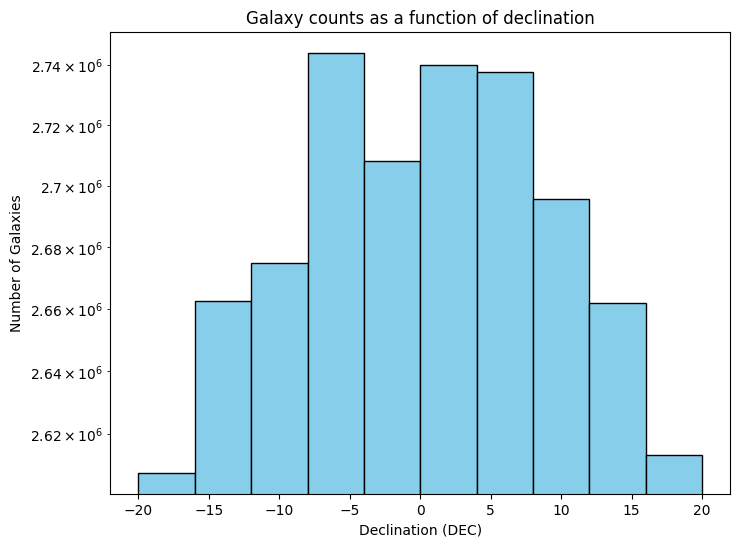

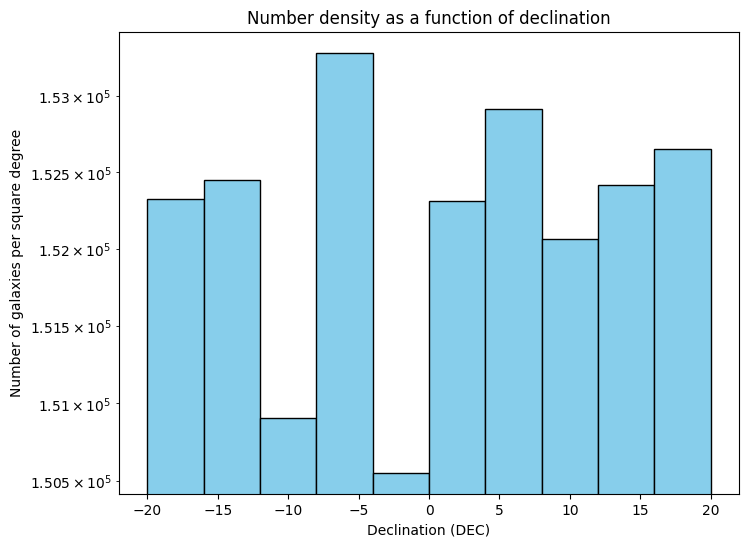

In [15]:
galaxy_counts, counts_per_deg2, dec_bins = calculate_counts_per_deg2(df)
plot_dec_bins(dec_bins, galaxy_counts)
plot_dec_bins_per_deg2(dec_bins, counts_per_deg2)

Figure Caption: Both plots have Declination on their X-axis.  The top panel shows the total number of galaxies.  The bottom panel shows the number of galaxies per square degree.  Note that they y-axis is displayed in a log scale, and shows a quite small range.  The goal of this plot is to explore the data a bit and see what variation we have as a function of declination bins.

## 3.0 Make Number density plot
This is a first pass at making a number density plot with just a single data file.  We divide the sample into 10 declination bins in order to do a jackknife sampling and obtain error bars for the plot. We choose to use constant dec bins instead of constant RA bins since area is function of cosine dec so we don't want to average over too much dec.

In [16]:
def jackknife_galaxy_count(df, grid_cells=10):
    """
    Calculate mean galaxy counts per square degree for each redshift bin, using jackknife resampling to estimate uncertainties.

    Parameters:
    df : pandas.DataFrame
        The DataFrame containing galaxy data, including 'RA', 'DEC', and 'redshift_observed' columns.
    grid_cells : int, optional
        Number of bins to divide the declination range into for jackknife resampling (default: 10).
    
    Returns:
    - mean_counts: List of mean galaxy counts per square degree for each redshift bin.
    - std_dev_counts: List of jackknife uncertainties (standard deviations) for each redshift bin.
    - z_bin_centers: central values of the redshift bins
    """
    original_galaxy_count = len(df)
    print(f"Original galaxy count: {original_galaxy_count}")
    

 
    # compute RA edges based on the data
    #keeping this in here in case we make bins over RA in the future
    ra_min = df['RA_shifted'].min()
    ra_max = df['RA_shifted'].max()
    ra_edges = np.linspace(ra_min, ra_max, grid_cells + 1)
    
    # Set up Declination bins for constant declination binning
    #manually fixing these here for this particular survey
    dec_min =  -20# df['DEC'].min()
    dec_max =  20# df['DEC'].max()
    dec_bins = np.linspace(dec_min, dec_max, grid_cells + 1)  # Create declination bins
    
    # Calculate bin areas for constant declination bins
    ra_width = np.diff(ra_edges)[0]  # Width of RA bins (all bins assumed equal width)
    bin_areas = get_bin_area(dec_bins, ra_width)

    # Initialize lists 
    mean_counts = []
    std_dev_counts = []
    sum_counts = []
    
    # Loop over the redshift bins
    for z_bin in df['z_bin'].cat.categories:
        # Step 8: Select galaxies within the current redshift bin
        df_z_bin = df[df['z_bin'] == z_bin].copy()

        # Step 9: Bin galaxies into Declination bins using precomputed dec_bins
        # Explicitly cast the 'ra_bin' column to 'category' before assignment
        df_z_bin['dec_bin'] = pd.cut(df_z_bin['DEC'], bins=dec_bins, include_lowest=True, right=False).astype('category')

        #df_z_bin.loc[:, 'dec_bin'] = pd.cut(df_z_bin['DEC'], bins=dec_bins, include_lowest=True, right=False)
        #df_z_bin.loc[:, 'dec_bin'] = df_z_bin['dec_bin'].astype('category')  # Use .loc to avoid SettingWithCopyWarning

        # Step 10: Count galaxies in each Declination bin
        galaxy_counts = df_z_bin.groupby('dec_bin', observed=False).size().values

        # Step 11: Calculate mean galaxy counts per square degree
        counts_per_deg2 = galaxy_counts / bin_areas

        # Step 12: Compute jackknife resampling to estimate uncertainties
        jackknife_means = []
        for i in range(len(counts_per_deg2)):
            jackknife_sample = np.delete(counts_per_deg2, i)
            jackknife_means.append(np.mean(jackknife_sample))

        # Step 13: Calculate mean and standard deviation of galaxy counts per square degree
        mean_counts.append(np.mean(counts_per_deg2))
        std_dev_counts.append(np.std(jackknife_means))

    return mean_counts, std_dev_counts


def plot_galaxy_counts_vs_redshift_with_jackknife(counts, std_dev_counts, z_bin_centers):
    """
    Plot the galaxy counts per square degree as a function of redshift with jackknife error bars.

    Parameters:
    - counts (numpy.ndarray): Array of galaxy counts per square degree for each redshift bin.
      Shape: (number of redshift bins,) or (1, number of redshift bins).
    - std_dev_counts (numpy.ndarray): Array of jackknife standard deviations for each redshift bin, 
      representing uncertainties. Shape: (number of redshift bins,).
    - z_bin_centers (numpy.ndarray): Array of central values of the redshift bins. 
      Shape: (number of redshift bins,).

    Notes:
    - The input arrays (`counts`, `std_dev_counts`, and `z_bin_centers`) must have the same length, 
      corresponding to the number of redshift bins.
    - The plot is designed specifically for redshifts in the range of 1.0 to 3.0 and may need adjustments 
      for datasets with different redshift ranges.
    """
    # Ensure counts is a NumPy array
    if isinstance(counts, list):
        counts = np.array(counts)
    
    # Flatten counts if it has a shape of [1, N]
    if counts.ndim == 2 and counts.shape[0] == 1:
        counts = counts.flatten()

    # setup figure
    plt.figure(figsize=(10, 6))

    # Plot with error bars (with jackknife standard deviation as error bars)
    plt.errorbar(z_bin_centers, counts, yerr=std_dev_counts, fmt='o', color='blue', 
                 ecolor='gray', elinewidth=2, capsize=3, label='Galaxy Counts per Square Degree (Jackknife)')
    plt.yscale('log')

    # Set x-range to redshifts between 1 and 3
    plt.xlim(1, 3.0)
    plt.ylim(1E1, 3E5)

    # Add labels and title
    plt.xlabel('Redshift', fontsize=12)
    plt.ylabel('Galaxy Count per Square Degree', fontsize=12)
    plt.title('Galaxy Counts per Square Degree vs Redshift with Jackknife Error Bars', fontsize=14)

    # Show the plot
    plt.legend()
    plt.show()
    plt.close()

Original galaxy count: 29382943
CPU times: user 1.41 s, sys: 84.2 ms, total: 1.49 s
Wall time: 1.49 s


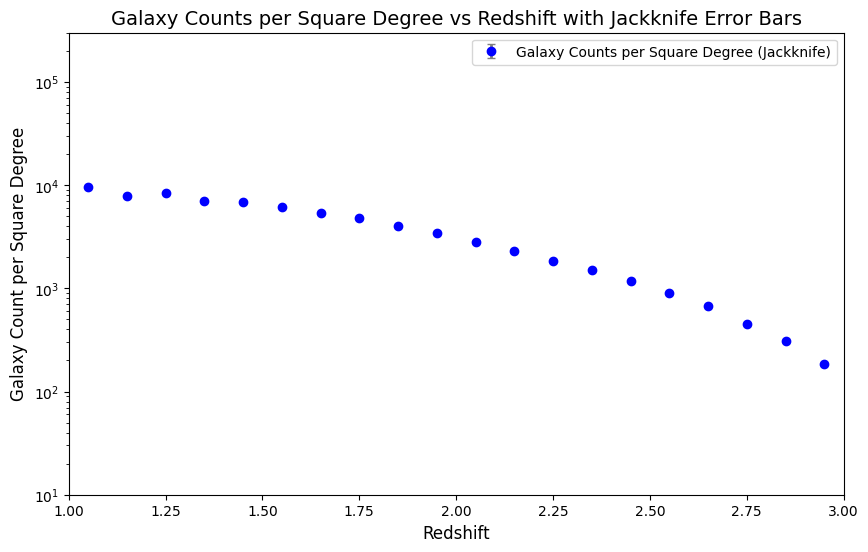

CPU times: user 1.41 s, sys: 84.2 ms, total: 1.49 s
Wall time: 1.49 s


In [17]:
%%time
#setup redshift binning here for consistency in the rest of the code
#these match our dataset, so only change if you want to reduce the range 
# or if you change the dataset

z_min = 1.0
z_max = 3.0
dz = 0.1

#do the counting
mean_counts, std_dev_counts = jackknife_galaxy_count(df, grid_cells=10)
#make the plot
plot_galaxy_counts_vs_redshift_with_jackknife(mean_counts, std_dev_counts, z_bin_centers)

Figure Caption: Number density plot.  Note that the jackknife error bars are displayed on the plot but they are smaller than the point size.  We see the expected shape of this plot, with a fall off toward higher redshift.

In [18]:
#cleanup memory when done with this file:
del df

## 4.0 Expand to out-of-memory sized catalogs
Originally this section attempted to use dask instead of pandas to hold the data and be able to do this work.  Dask is supposed to be able to do this sort of magic in the background with out of memory catalogs, but in reality, this does not seem to be possible, or at least not possible with a week or so of working on it.  Instead, we will read in the catalogs one at a time, store counts of mean and standard deviation per square degree and then move on to the next catalog.

In [19]:
def calculate_area(df):
    """
    Calculate the total survey area in square degrees based on DEC range and RA width.

    Parameters:
    - df: The DataFrame containing galaxy data.

    Returns:
    - area: Total survey area in square degrees.
    """
    ra_min = df['RA_shifted'].min()
    ra_max = df['RA_shifted'].max()
    dec_min = df['DEC'].min()
    dec_max = df['DEC'].max()
     
    # Step 4: Calculate area
    ra_width = ra_max - ra_min 
    dec_height = dec_max - dec_min
 
    # Approximate area calculation
    dec_center = (dec_min + dec_max) / 2
    area = ra_width * dec_height * np.cos(np.radians(dec_center))

    return area

In [20]:
def galaxy_counts_per_hdf5_binned(
    df,
    z_bins,
    z_bin_centers,
    find_halpha_bins=False,
    halpha_flux_thresholds=None,
):
    """
    Calculate the galaxy counts per square degree for each redshift bin.
    Optionally calculate counts for Halpha flux bins.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame containing galaxy data.
    - zbins (): edges of the redshift bins
    - z_bin_centers (numpy.ndarray): Array of central values of the redshift bins.
    - find_halpha_bins (bool, optional): Whether to calculate counts for Halpha bins (default: False).
    - halpha_flux_thresholds (list, optional): Custom thresholds for Halpha flux binning. If None, default thresholds are used.

    Returns:
    - counts_per_deg2 (numpy.ndarray): Array of galaxy counts per square degree for each redshift bin.
    - halpha_counts (numpy.ndarray): Counts for each Halpha bin (if `find_halpha_bins` is True).
    """
    # Default Halpha flux thresholds if not provided
    if find_halpha_bins and halpha_flux_thresholds is None:
        halpha_flux_thresholds = [0.5e-16, 0.7e-16, 0.9e-16, 1.1e-16, 1.3e-16, 1.5e-16, 1.7e-16, 1.9e-16]
        
    # Calculate survey area
    area = calculate_area(df)

    # Initialize counts
    counts = np.zeros((1, len(z_bins) - 1))
    halpha_counts = None

    # Prepare for Halpha binning if requested
    if find_halpha_bins:
        halpha_counts = np.zeros((len(halpha_flux_thresholds), len(z_bins) - 1))

    # Group data by redshift bin
    grouped = df.groupby("z_bin", observed= False)

    for i, (z_bin, group) in enumerate(grouped):
        # Count galaxies in the redshift bin
        galaxy_count = len(group)
        counts[0, i] = galaxy_count

        if find_halpha_bins:
            # Count galaxies for each Halpha bin within the current redshift bin
            for j, threshold in enumerate(halpha_flux_thresholds):
                halpha_count = len(group[group["flux_Halpha6563"] > threshold])
                halpha_counts[j, i] = halpha_count
                #print(f"redshift: {z_bin}, threshold: {threshold}, halpha_count: {halpha_count}, count: {galaxy_count}")


    # Sort results based on z_bin_centers
    sorted_indices = np.argsort(z_bin_centers)
    counts_per_deg2 = (counts / area)[:, sorted_indices]

    if find_halpha_bins:
        # Normalize Halpha counts to counts per square degree
        halpha_counts_per_deg2 = (halpha_counts / area)[:, sorted_indices]
    else:
        halpha_counts_per_deg2 = None

    return counts_per_deg2, halpha_counts_per_deg2
  
def plot_binned_galaxy_counts_vs_redshift_with_jackknife(
    counts_summary, z_bin_centers, halpha_flux_thresholds, halpha_summary,
    ):
    """
    Plots galaxy counts per square degree as a function of redshift with jackknife error bars.

    This function visualizes the galaxy number density using binned redshift data. It includes 
    jackknife-based uncertainty estimates and optionally plots counts for Hα flux-selected bins.

    Parameters:
    - counts_summary (dict): A dictionary containing:
        - 'sum_counts' (numpy.ndarray): Array of total galaxy counts per square degree for each redshift bin.
        - 'std_dev_counts' (numpy.ndarray): Array of jackknife standard deviations for each redshift bin.
    - z_bin_centers (numpy.ndarray): Array of central values of the redshift bins.
    - halpha_flux_thresholds (list, optional): List of Hα flux threshold values (used for labeling the lines).
    - halpha_summary (dict, optional): A dictionary containing:
        - 'halpha_sum_counts' (numpy.ndarray): Counts for each Hα flux-selected bin.
        - 'halpha_std_dev_counts' (numpy.ndarray): Jackknife standard deviations for each Hα flux-selected bin.

    Notes:
    - The input arrays in `counts_summary` and `halpha_summary` must have the same length as `z_bin_centers`.
    - The function automatically sets the y-axis to a logarithmic scale (`plt.yscale("log")`).
    - The x-axis is limited to the redshift range [1, 3].
    - The function ensures proper memory management by explicitly closing the plot.
    """
    # Unpack counts_summary
    counts = counts_summary["sum_counts"]
    std_dev_counts = counts_summary["std_dev_counts"]

    # Unpack halpha_summary if provided, otherwise set to None
    if halpha_summary is not None:
        halpha_counts = halpha_summary.get("halpha_sum_counts")
        halpha_std_dev_counts = halpha_summary.get("halpha_std_dev_counts")
    else:
        halpha_counts = None
        halpha_std_dev_counts = None

    # Ensure counts is a NumPy array
    if isinstance(counts, list):
        counts = np.array(counts)

    # Flatten counts if it has a shape of [1, N]
    if counts.ndim == 2 and counts.shape[0] == 1:
        counts = counts.flatten()

    # Setup figure
    plt.figure(figsize=(10, 6))

    # Plot the main counts with error bars
    jackknife_line = plt.errorbar(
        z_bin_centers, counts, yerr=std_dev_counts, fmt="o-", color="blue",
        ecolor="blue", elinewidth=2, capsize=3, label="All Galaxy Counts per Square Degree (Jackknife)"
    )

    # Plot Hα bins if the data is present
    halpha_lines = []
    if halpha_flux_thresholds is not None and halpha_counts is not None:
        for i in range(len(halpha_flux_thresholds)):
            label = f"Flux Hα > {halpha_flux_thresholds[i]:.1e} erg/s/cm²"
            line, = plt.plot(z_bin_centers, halpha_counts[i], marker="o", label=label)
            halpha_lines.append(line)

    # Adjust legend order if Hα lines were added
    if halpha_lines:
        handles, labels = plt.gca().get_legend_handles_labels()
        new_order = [jackknife_line] + halpha_lines  
        plt.legend(new_order, [labels[handles.index(h)] for h in new_order])
    else:
        plt.legend()

    # Set log scale for y-axis and limit the x-axis
    plt.yscale("log")
    plt.xlim(1, 3.0)
    
    # Add labels and title
    plt.xlabel("Redshift", fontsize=12)
    plt.ylabel("Galaxy Count per Square Degree", fontsize=12)
    plt.title("Number Density with Jackknife Error Bars", fontsize=14)
    
    # Display the plot
    plt.show()
    plt.close()


def jackknife_wrapper(file_list,  halpha_flux_thresholds, find_halpha_bins=False):
    """
    Performs jackknife resampling over multiple HDF5 files to estimate uncertainties 
    in galaxy counts per square degree for each redshift bin. Optionally calculates 
    counts for Hα flux-selected bins.

    Parameters:
    - file_list (list of str): List of file paths to HDF5 datasets to process.
    - halpha_flux_thresholds (list): List of Hα flux thresholds used for binning (if `find_halpha_bins` is True).
    - find_halpha_bins (bool, optional): Whether to calculate counts for Hα bins (default: False).

    Returns:
    - counts_summary (dict): A dictionary containing:
        - 'sum_counts' (numpy.ndarray): Summed galaxy counts across all HDF5 files for each redshift bin.
          Shape: (number of redshift bins,).
        - 'std_dev_counts' (numpy.ndarray): Jackknife standard deviations for galaxy counts per square degree.
          Shape: (number of redshift bins,).
       Shape: (number of redshift bins,).
    - halpha_summary (dict or None): A dictionary containing Hα bin statistics if `find_halpha_bins` is True, otherwise `None`. 
      When present, the dictionary includes:
        - 'halpha_sum_counts' (numpy.ndarray): Summed counts for each Hα bin.
          Shape: (number of Hα bins, number of redshift bins).
        - 'halpha_std_dev_counts' (numpy.ndarray): Jackknife standard deviations for Hα bins.
          Shape: (number of Hα bins, number of redshift bins).

    Notes:
    - The function loads multiple HDF5 files and extracts galaxy counts using `galaxy_counts_per_hdf5_binned()`.
    - Jackknife resampling is applied across files to compute standard deviations.
    - The function saves `all_counts` to a NumPy file for debugging purposes.
    - If `find_halpha_bins` is False, `halpha_summary` is returned as `None` to indicate that Hα binning was not performed.
    """
    #fix these in case the above cells are not run
    ra_min1=330
    z_min = 1.0
    z_max = 3.0
    dz = 0.1
    columns_to_keep = ['RA', 'DEC', 'redshift_observed', 'flux_Halpha6563']
    columns_to_convert = ['redshift_observed', 'flux_Halpha6563']

    #setup to track counts
    all_counts = []
    all_halpha_counts = [] if find_halpha_bins else None

    for file in file_list:
        # Load data from the file
        df = read_hdf5_to_pandas(file, columns_to_keep, columns_to_convert)

        #pre-process dataset
        df, z_bins, z_bin_centers = assign_redshift_bins(df, z_min, z_max, dz)
        df['RA_shifted'] = (df['RA'] - ra_min1) % 360  # Shift RA to continuous range

        # Get counts (with or without Halpha binning)
        result = galaxy_counts_per_hdf5_binned(
            df, z_bins, z_bin_centers, find_halpha_bins=find_halpha_bins,
            halpha_flux_thresholds=halpha_flux_thresholds
        )
        
        counts_per_deg2, halpha_counts_per_deg2 = result 
        all_counts.append(counts_per_deg2.flatten())  #make sure shape is correct
        
        if find_halpha_bins:
            all_halpha_counts.append(halpha_counts_per_deg2)

        # Explicitly delete DataFrame for improved memory management
        del df

    # Save all_counts to a file for debugging or post-processing
    os.makedirs("output", exist_ok=True)
    np.save("output/all_counts.npy", all_counts)

    # Convert to NumPy array for easier manipulation
    all_counts = np.array(all_counts)

    #debugging
    print("all_counts shape:", all_counts.shape)
    print("all_counts sample:", all_counts[:3])  # preview first 3 entries
    print("all_counts variance:", np.var(all_counts, axis=0))
    print("all_counts dtype:", all_counts.dtype)
    
    if find_halpha_bins:
        all_halpha_counts = np.array(all_halpha_counts)

    # Compute sum counts
    sum_counts = np.sum(all_counts, axis=0)

    # Compute jackknife standard deviations for galaxy counts
    std_dev_counts = np.sqrt(
        (len(all_counts) - 1) * np.var(all_counts, axis=0, ddof=0)
    )

    # Create counts summary dictionary
    counts_summary = {
        "sum_counts": sum_counts,
        "std_dev_counts": std_dev_counts
    }

    # Compute jackknife standard deviations for Halpha counts (if applicable)
    if find_halpha_bins:
        halpha_sum_counts = np.sum(all_halpha_counts, axis=0)
        halpha_std_dev_counts = np.sqrt(
            (len(all_halpha_counts) - 1) * np.var(all_halpha_counts, axis=0, ddof=0)
        )
        # Create halpha counts summary dictionary
        halpha_summary = {
            "halpha_sum_counts": halpha_sum_counts,
            "halpha_std_dev_counts": halpha_std_dev_counts
        }
    else:
        halpha_summary = None  # No Halpha binning

    return counts_summary, halpha_summary

all_counts shape: (1, 20)
all_counts sample: [[908.19889809 747.2333674  794.9342837  676.17631576 655.19747312
  588.94982189 513.17670351 456.29600034 383.57721419 330.13751134
  267.43061388 217.22499701 175.30681804 144.16250588 112.40633963
   85.80426641  63.65060463  43.55867883  29.37146612  17.62327474]]
all_counts variance: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
all_counts dtype: float64
CPU times: user 4.01 s, sys: 1.38 s, total: 5.4 s
Wall time: 5.46 s


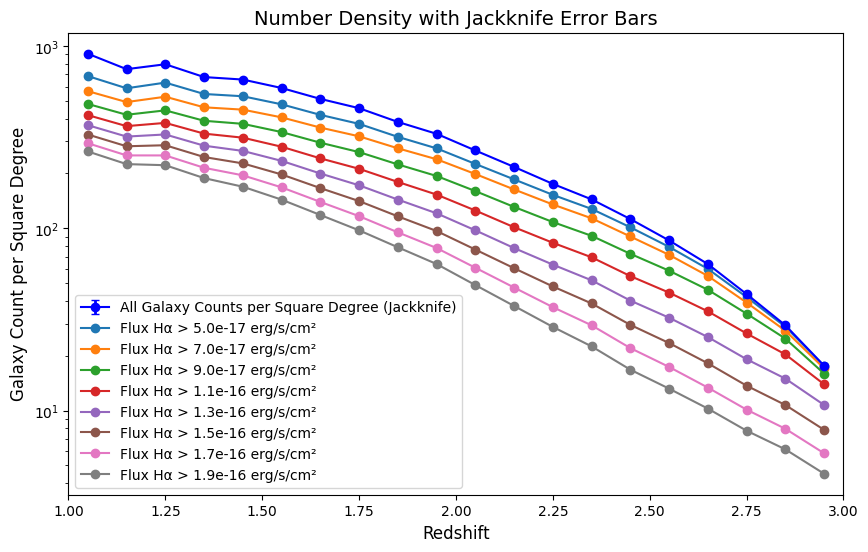

CPU times: user 4.01 s, sys: 1.38 s, total: 5.4 s
Wall time: 5.46 s


In [21]:
%%time

# This uses data downloaded in section 1 above.  
# If you want to run this with more data, return to section 1 to get that downloaded.
download_dir = 'downloaded_hdf5_files'
# Get all HDF5 files from the directory
file_paths = [os.path.join(download_dir, f) for f in os.listdir(download_dir) if f.endswith('.hdf5')]

#out of consideration for the size of these files and the amount of memory required to work with them
# we only keep the columns that we are going to use and convert some to 32bit instead of 64 where 
# the higher precision is not necessary to the science
columns_to_keep = ['RA', 'DEC', 'redshift_observed', 'flux_Halpha6563']
columns_to_convert = ['redshift_observed', 'flux_Halpha6563']

# Run jackknife with Halpha binning enabled
halpha_flux_thresholds=[0.5e-16, 0.7e-16, 0.9e-16, 1.1e-16, 1.3e-16, 1.5e-16, 1.7e-16, 1.9e-16]
results = jackknife_wrapper(
    file_paths, halpha_flux_thresholds, find_halpha_bins=True
)

# Unpack results
counts_summary, halpha_summary = results

# Plot the results
plot_binned_galaxy_counts_vs_redshift_with_jackknife(
    counts_summary, z_bin_centers, halpha_flux_thresholds, halpha_summary)

Figure Caption: Number Density plots color coded by Halpha flux.  Slight variations are noted in the shape of the curves as a function of Halpha flux, especially at higher redshifts.  This plot may be a factor of 10 below the section 3 number density plot if you have not let it download all 10 input files.  The 10 input files cover the same area on the sky, so the density will look smaller if fewer files are used.

### 4.1 Explore jackknife uncertainties
The uncertainties are plotted as error bars on the data points above.  There are no jackknife uncertainties if you are only using one file, so they will in that case not be visible on the plot.  This section is for the case where you are using more than one downloaded input file.  Here we explore and plot the jackknife uncertainties in a way that makes them visible.

In [22]:
def plot_jackknife_fractional_uncertainty(z_bin_centers, counts, std_dev_counts):
    """
    Plots the fractional jackknife uncertainty (σ / N) as a function of redshift.
    
    Parameters
    ----------
    z_bin_centers : array-like
        The center of each redshift bin.
    counts : array-like
        The total galaxy counts per redshift bin.
    std_dev_counts : array-like
        The jackknife standard deviation per redshift bin.
    """
    fractional_uncertainty = std_dev_counts / counts

    plt.figure(figsize=(8, 5))
    plt.plot(z_bin_centers, fractional_uncertainty, marker='o', linestyle='-', color='purple')
    #plt.ylim(0, 0.01)
    plt.xlabel('Redshift')
    plt.ylabel('Fractional Uncertainty')
    plt.title('Jackknife Fractional Uncertainty vs. Redshift')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()

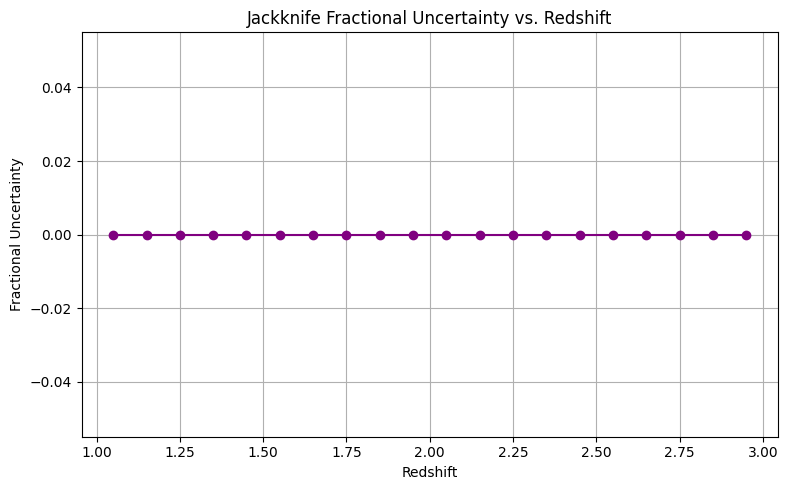

In [23]:
#make fractional uncertainty plot
counts_per_deg2 = counts_summary["sum_counts"].flatten()
std_dev_counts = counts_summary["std_dev_counts"].flatten()
plot_jackknife_fractional_uncertainty(z_bin_centers, counts_per_deg2, std_dev_counts)

Figure Caption:  The fractional uncertainty is the standard deviation from jackknife sampling divided by the number of galaxies per square degree, here plotted as a function of redshift.  Note that if you are using only 1 downloaded file this will be a flat plot with no uncertainties.  However, if you are using all 10 input files, you will see the expected rise in uncertainty with increasing redshift.

## Acknowledgements

- [IPAC-IRSA](https://irsa.ipac.caltech.edu/)

## About this notebook
**Authors**: Jessica Krick in conjunction with the IPAC Science Platform Team

**Contact:** [IRSA Helpdesk](https://irsa.ipac.caltech.edu/docs/help_desk.html) with questions
or problems.

**Updated:** 2025-04-01

**Runtime:** As of the date above, running on the [Fornax Science Platform](https://pcos.gsfc.nasa.gov/Fornax/), this notebook takes about 9 minutes to run to completion on
a machine with 8GB RAM and 4 CPU.
This runtime inlcudes the notebook as is, using only one datafile out of 10.  Runtime will be greater than 30 min. longer if the code is allowed to download and work with all 10 datafiles.